# Lesson 6: pets revisited

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

In [3]:
bs = 64

In [5]:
path = untar_data(URLs.PETS) / 'images'

## Data augmentation

In [6]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)

In [7]:
doc(get_transforms)

In [8]:
src = ImageItemList.from_folder(path).random_split_by_pct(0.2, seed=2)

In [9]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
            .transform(tfms, size=size, padding_mode=padding_mode)
            .databunch(bs=bs).normalize(imagenet_stats))

In [10]:
data = get_data(224, bs, 'zeros')

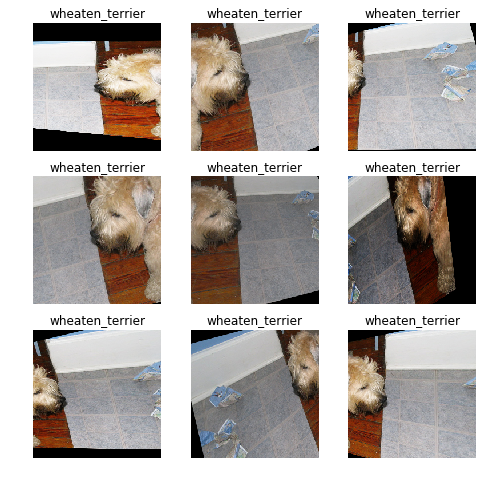

In [11]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [12]:
data = get_data(224, bs)

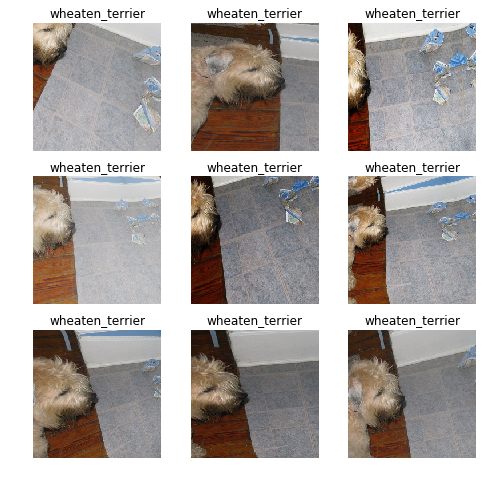

In [13]:
plot_multi(_plot, 3, 3, figsize=(8,8))

## Train a model

In [14]:
gc.collect()

14593

In [15]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


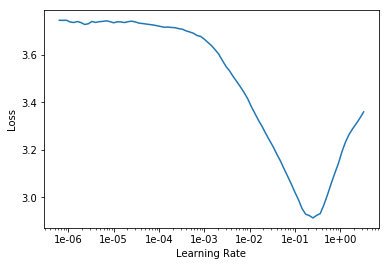

In [20]:
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,2.431377,1.230201,0.290934
2,1.439160,0.372741,0.102842
3,0.878912,0.300877,0.087957


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


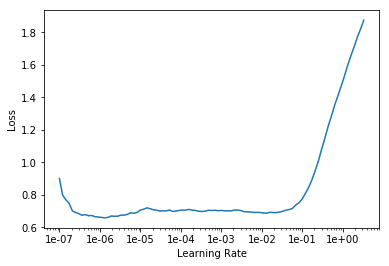

In [24]:
learn.recorder.plot(skip_start=0)

In [25]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate
1,0.694553,0.305744,0.079161
2,0.650280,0.301226,0.070365


In [26]:
data = get_data(352, bs)
learn.data = data

In [27]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


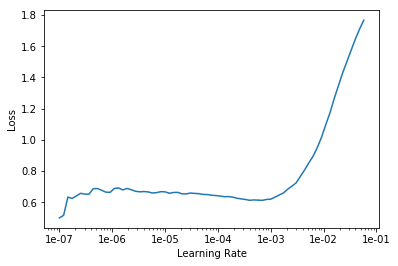

In [29]:
learn.recorder.plot(skip_start=0)

In [30]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate
1,0.599940,0.277238,0.057510
2,0.561108,0.279816,0.056157


In [31]:
learn.save('352')

In [ ]:
learn.save('352')

## Convolution kernel

In [32]:
data = get_data(352,16)

In [33]:
learn = create_cnn(data, models.resnet34, metrics=error_rate, bn_final=True).load('352')

Category Ragdoll

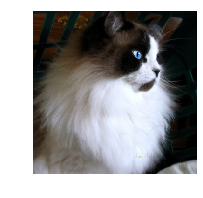

In [66]:
idx = 33
x, y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [67]:
k = tensor([
    [0.  , -5/3, 1],
    [-5/3, -5/3, 1],
    [1.  , 1   , 1],
]).expand(1, 3, 3, 3) / 6

In [68]:
k

tensor([[[[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]],

         [[ 0.0000, -0.2778,  0.1667],
          [-0.2778, -0.2778,  0.1667],
          [ 0.1667,  0.1667,  0.1667]]]])

In [69]:
k.shape

torch.Size([1, 3, 3, 3])

In [70]:
from fastai.callbacks.hooks import *

In [75]:
t = data.valid_ds[idx][0].data
t.shape

torch.Size([3, 352, 352])

In [76]:
t[None].shape

torch.Size([1, 3, 352, 352])

In [77]:
edge = F.conv2d(t[None], k)

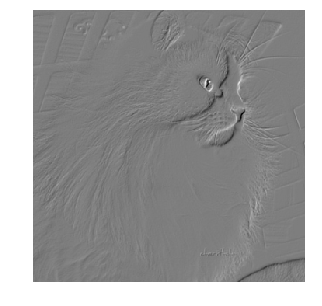

In [78]:
show_image(edge[0], figsize=(5,5))

In [79]:
data.c

37

In [80]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [ ]:
learn.summary()

Input Size override by Learner.data.train_dl
Input Size passed in: 16 

Layer (type)               Output Shape         Param #   
Conv2d                    [16, 64, 176, 176]   9408                
________________________________________________________________________________
BatchNorm2d               [16, 64, 176, 176]   128                 
________________________________________________________________________________
ReLU                      [16, 64, 176, 176]   0                   
________________________________________________________________________________
MaxPool2d                 [16, 64, 88, 88]     0                   
________________________________________________________________________________
Conv2d                    [16, 64, 88, 88]     36864               
________________________________________________________________________________
BatchNorm2d               [16, 64, 88, 88]     128                 
________________________________________________________

## Heatmap

In [82]:
m = learn.model.eval()

In [83]:
xb, _ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [84]:
from fastai.callbacks.hooks import *

In [85]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a:
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0, int(cat)].backward()
    return hook_a, hook_g

In [86]:
hook_a, hook_g = hooked_backward() # hook activations, hook gradients

In [87]:
acts = hook_a.stored[0].cpu() # class attribute self.stored. move tensor from GPU back to CPU
acts.shape

torch.Size([512, 11, 11])

In [88]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

In [93]:
def show_heatmap(hm):
    _, ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma')

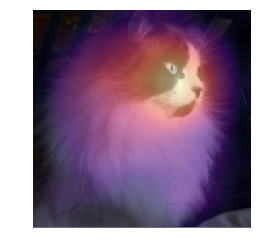

In [94]:
show_heatmap(avg_acts)

## Gradient-weighted Class Activation Mapping (Grad-CAM)

Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [124]:
# Sanity check
type(hook_g.stored), len(hook_g.stored), type(hook_g.stored[0]), hook_g.stored[0].shape, hook_g.stored[0][0].shape

(list,
 1,
 torch.Tensor,
 torch.Size([1, 512, 11, 11]),
 torch.Size([512, 11, 11]))

In [128]:
# Sanity check
grad.mean(1).shape

torch.Size([512, 11])

In [125]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1) # mean over axis 1: [512, 11, 11] -> [512, 11] -> [512]
grad.shape, grad_chan.shape

(torch.Size([512, 11, 11]), torch.Size([512]))

In [130]:
# Sanity check
print(grad_chan[...,None,None].shape) # None is effectively adding a new dim to tensor
print(acts.shape)

torch.Size([512, 1, 1])
torch.Size([512, 11, 11])


In [131]:
# Sanity check
(acts*grad_chan[...,None,None]).shape

torch.Size([512, 11, 11])

In [132]:
mult = (acts*grad_chan[...,None,None]).mean(0)

In [133]:
# Sanity check
mult.shape

torch.Size([11, 11])

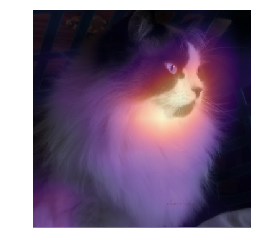

In [134]:
show_heatmap(mult)

In [139]:
fn = path / '../../other/ragdoll_and_dog.jpg'

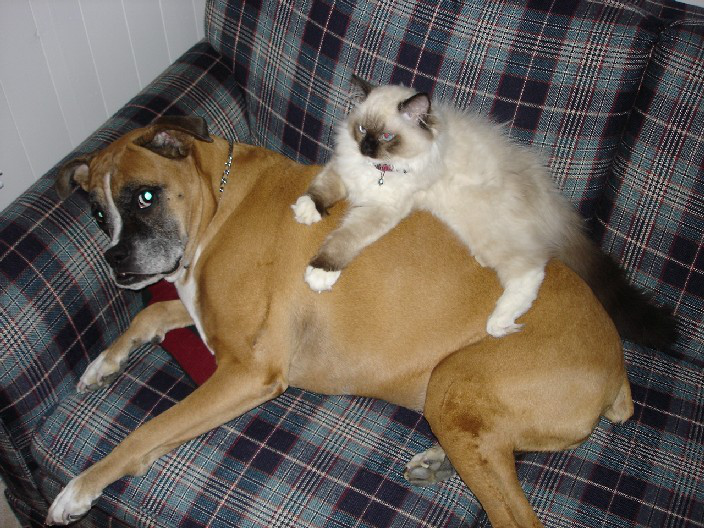

In [140]:
x = open_image(fn); x

In [141]:
xb, _ = data.one_item(x)

In [142]:
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [143]:
hook_a, hook_g = hooked_backward()

In [144]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

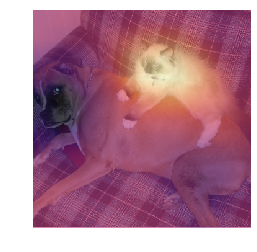

In [145]:
show_heatmap(mult)

In [146]:
data.classes[0]

'Abyssinian'

In [147]:
hook_a, hook_g = hooked_backward(0)

In [148]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

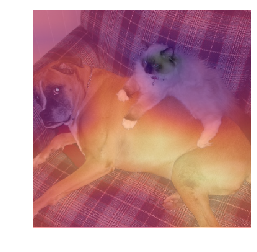

In [149]:
show_heatmap(mult)